In [1]:
import mpmath as mp
from sage.all import graphs, set_random_seed
import random

mp.mp.dps = 60
TARGET_DIGITS = 37

# Initialize the Heawood Graph
G = graphs.HeawoodGraph()



In [2]:

# The symmetry is defined by mapping vertex i -> 13-i.
# Conditions:
# 1. x_i = -x_{13-i}  (Mirrored across x=0)
# 2. y_i = y_{13-i}   (Same height)
# 3. y_0 = 0.0, y_1 = 1.0 (Fixed anchors)

# We solve for 12 variables:
# x[0]...x[6] (7 variables)
# y[2]...y[6] (5 variables) -> y[0], y[1] are fixed
# Total = 12 variables.

# Identify the unique edges (constraints) modulo the symmetry.
# The Heawood graph has 21 edges. 
# Under this symmetry, there are 3 fixed edges (mapping to themselves) 
# and 9 pairs of symmetric edges. Total unique constraints = 3 + 9 = 12.
# This results in a square system (12 vars, 12 eqs).

unique_edge_constraints = []
seen_edges = set()

for u, v in G.edges(labels=False):
    # Standardize edge tuple
    e_original = tuple(sorted((u, v)))
    # Calculate symmetric partner edge
    e_symmetric = tuple(sorted((13 - u, 13 - v)))
    
    if e_original not in seen_edges:
        unique_edge_constraints.append(e_original)
        seen_edges.add(e_original)
        seen_edges.add(e_symmetric)

print(f"System Check: {len(unique_edge_constraints)} unique edge constraints for 12 variables.")

System Check: 12 unique edge constraints for 12 variables.


In [3]:
def reconstruct_points(params):
    """
    Reconstructs all 14 (x,y) points from the 12 optimization parameters.
    """
    x = [mp.mpf(0)] * 14
    y = [mp.mpf(0)] * 14
    
    # 1. Unpack independent variables
    # params[0..6] -> x[0..6]
    for i in range(7):
        x[i] = params[i]
        
    # params[7..11] -> y[2..6]
    y[0] = mp.mpf(0)
    y[1] = mp.mpf(1)
    for i in range(5):
        y[i+2] = params[7+i]
        
    # 2. Apply Symmetry for vertices 7..13
    for i in range(7):
        j = 13 - i
        x[j] = -x[i]  # Mirror x
        y[j] =  y[i]  # Copy y
        
    return x, y

def equation_residuals(*params):
    """
    Returns the list of errors for the unit distance constraints.
    target: (x_u - x_v)^2 + (y_u - y_v)^2 - 1 = 0
    """
    x, y = reconstruct_points(params)
    residuals = []
    
    for u, v in unique_edge_constraints:
        dist_sq = (x[u] - x[v])**2 + (y[u] - y[v])**2
        residuals.append(dist_sq - 1)
    # add a random additional constraint
    residuals.append(x[3] + x[5])
    # Pin down two vertices
    residuals.append(y[0])
    residuals.append(y[1] - 1)
    
    return residuals

In [4]:

# Configuration
MAX_ATTEMPTS = 100
MIN_DIST_EPS = 1e-6  # Minimum allowed distance between any two vertices

print(f"Attempting to solve (max {MAX_ATTEMPTS} attempts)...")

success = False

# instead of fixing a random seed or enforce non-degeneracy in some other way, 
# we allow to run a couple of times to find a non-degenerate solution

for attempt in range(MAX_ATTEMPTS):
    # 1. Generate new random guess
    initial_guess = [random.uniform(-1.0, 1.0) for _ in range(12)]
    
    try:
        # 2. Try to solve
        # We suppress error printing here to keep the output clean during the loop
        solution_matrix = mp.findroot(equation_residuals, initial_guess, 
                                      maxsteps=4000, 
                                      tol=10**(-TARGET_DIGITS + 5))
        solution = list(solution_matrix)
        
        # 3. Reconstruct points
        final_x, final_y = reconstruct_points(solution)
        
        # 4. Check against degeneracy (Vertices falling on top of each other)
        # We check the distance between EVERY pair of vertices (not just edges)
        min_pairwise_dist = float('inf')
        
        # Check all pairs (i, j)
        is_degenerate = False
        for i in range(14):
            for j in range(i + 1, 14):
                d2 = (final_x[i] - final_x[j])**2 + (final_y[i] - final_y[j])**2
                if d2 < MIN_DIST_EPS**2:
                    is_degenerate = True
                    break
            if is_degenerate:
                break
        
        if is_degenerate:
            print(f"{attempt=} found degenerate solution")
            # If solution is valid mathematically but degenerate geometrically, skip it
            continue
            
        # If we reached here, we found a valid, non-degenerate solution
        print(f"Success on attempt #{attempt}!")
        success = True
        break

    except ValueError:
        # Solver diverged or failed for this random seed; try the next one
        print(f"{attempt=} failed to find solution")
        continue

if success:
    print("\nValid non-degenerate solution found:")
    print(f"{'idx':<4} | {'x':<40} | {'y':<40}")
    print("-" * 88)
    
    def fmt(val):
        return mp.nstr(val, TARGET_DIGITS)

    for i in range(14):
        print(f"{i:<4} | {fmt(final_x[i]):<40} | {fmt(final_y[i]):<40}")


else:
    print("\nFailed to find a valid solution after 100 attempts.")

Attempting to solve (max 100 attempts)...
attempt=0 failed to find solution
attempt=1 failed to find solution
attempt=2 failed to find solution
attempt=3 found degenerate solution
attempt=4 failed to find solution
attempt=5 found degenerate solution
attempt=6 failed to find solution
attempt=7 found degenerate solution
attempt=8 found degenerate solution
attempt=9 failed to find solution
Success on attempt #10!

Valid non-degenerate solution found:
idx  | x                                        | y                                       
----------------------------------------------------------------------------------------
0    | 0.5                                      | 0.0                                     
1    | 0.5                                      | 1.0                                     
2    | 1.254365877462440255419371836216175757   | 0.3435457952603833209970277665586791672 
3    | 0.2543658774624402554193718362161757571  | 0.3435457952603833209970277665586791672 
4   

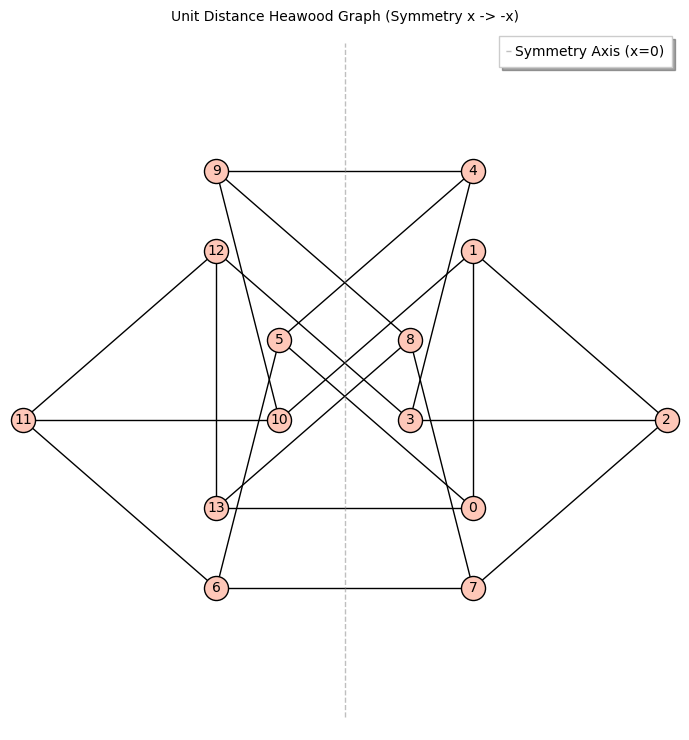

In [5]:
from sage.plot.line import line

# 1. Convert mpmath coordinates to standard floats for plotting
# SageMath's plotting library expects standard python floats
pos_dict = {}
for i in range(14):
    pos_dict[i] = (float(final_x[i]), float(final_y[i]))

# 2. Create the graph plot
# aspect_ratio=1 is CRITICAL to verify visual unit distances
P = G.plot(pos=pos_dict, 
           aspect_ratio=1, 
           figsize=10, 
           vertex_size=300,
           title="Unit Distance Heawood Graph (Symmetry x -> -x)")

# 3. Add the symmetry axis (x=0) for reference
# distinct y-values to determine the length of the axis line
all_ys = [p[1] for p in pos_dict.values()]
y_min, y_max = min(all_ys), max(all_ys)
axis_line = line([(0, y_min - 0.5), (0, y_max + 0.5)], 
                 linestyle="--", 
                 color="grey", 
                 alpha=0.5, 
                 legend_label="Symmetry Axis (x=0)")

# 4. Show the combined plot
(P + axis_line).show(axes=False)

In [6]:
from sage.all import algdep, AA, RealField, ZZ

# 1. Setup Precision for conversion
# We need to convert mpmath objects to Sage's RealField for algdep
R = RealField(150) # Use high precision to ensure algdep catches the pattern

def recover_algebraic(val_mp, degree=3):
    """
    Takes an mpmath float, finds its minimal polynomial using algdep,
    and returns the exact Algebraic Real (AA) number.
    """
    # Convert mpmath to Sage RealField
    val_sage = R(val_mp)
    
    # Use algdep to find the polynomial relationship
    # We look for a polynomial of degree up to 3
    poly = algdep(val_sage, degree)
    
    # Find the roots of this polynomial in the Algebraic Real Field (AA)
    # AA represents exact algebraic numbers distinguished by interval isolation
    roots_aa = poly.roots(ring=AA, multiplicities=False)
    
    # Find the root closest to our numerical value
    # We compare the exact root (cast to float) with our original value
    best_root = min(roots_aa, key=lambda r: abs(R(r) - val_sage))
    
    return best_root, poly

# -----------------------------------------------------------------------------
# 2. Recover Exact Parameters
# -----------------------------------------------------------------------------
print("Recovering algebraic numbers for the 12 parameters...")
print(f"{'Idx':<4} | {'Deg':<3} | {'Polynomial':<30} | {'Exact Value (approx)'}")
print("-" * 80)

# We recovered 'solution' (the list of 12 params) in the previous step.
# We will convert them to exact AA numbers.
exact_params = []
param_polys = []

for i, val in enumerate(solution):
    root, poly = recover_algebraic(val, degree=3)
    exact_params.append(root)
    param_polys.append(poly)
    
    # Print formatted output
    print(f"{i:<4} | {poly.degree():<3} | {str(poly):<30} | {root.n(digits=10)}")

# -----------------------------------------------------------------------------
# 3. Reconstruct Exact Graph Coordinates
# -----------------------------------------------------------------------------

# Initialize lists with AA(0)
exact_x = [AA(0)] * 14
exact_y = [AA(0)] * 14

# 1. Unpack independent variables (params[0..6] -> x[0..6])
for i in range(7):
    exact_x[i] = exact_params[i]

# 2. Unpack y variables (params[7..11] -> y[2..6])
exact_y[0] = AA(0)
exact_y[1] = AA(1)
for i in range(5):
    exact_y[i+2] = exact_params[7+i]

# 3. Apply Symmetry for vertices 7..13 exactly
for i in range(7):
    j = 13 - i
    exact_x[j] = -exact_x[i]  # Exact negation
    exact_y[j] =  exact_y[i]  # Exact copy

# -----------------------------------------------------------------------------
# 4. Verification in Exact Arithmetic
# -----------------------------------------------------------------------------
print("\nVerifying unit distances in Exact Arithmetic (AA)...")
print("(Checking (x_u - x_v)^2 + (y_u - y_v)^2 == 1)")
print("-" * 60)

all_valid = True
errors = []

# Check ALL edges in the graph, not just the unique ones
for u, v in G.edges(labels=False):
    # Calculate squared Euclidean distance using exact arithmetic
    dx = exact_x[u] - exact_x[v]
    dy = exact_y[u] - exact_y[v]
    dist_sq = dx**2 + dy**2
    
    # Check for EXACT equality with 1
    # In AA, '==' checks algebraic equality, not approximate
    is_unit = (dist_sq == 1)
    
    if not is_unit:
        all_valid = False
        print(f"Edge ({u}, {v}) FAILED: Length^2 = {dist_sq}")
    else:
        # Just print a few dots to show progress or specific confirmations
        pass

if all_valid:
    print("SUCCESS: All edges are exactly unit length.")
    print("The embedding is algebraically exact.")
else:
    print("FAILURE: Some edges are not unit length.")

# -----------------------------------------------------------------------------
# 5. Display the Unique Minimal Polynomials Found
# -----------------------------------------------------------------------------
print("\nUnique Minimal Polynomials found in the solution:")
unique_polys = sorted(list(set(param_polys)), key=lambda p: (p.degree(), str(p)))
for p in unique_polys:
    print(f"Deg {p.degree()}: {p}")

Recovering algebraic numbers for the 12 parameters...
Idx  | Deg | Polynomial                     | Exact Value (approx)
--------------------------------------------------------------------------------
0    | 1   | 2*x - 1                        | 0.5000000000
1    | 1   | 2*x - 1                        | 0.5000000000
2    | 3   | 16*x^3 - 18*x - 9              | 1.254365877
3    | 3   | 16*x^3 + 48*x^2 + 30*x - 11    | 0.2543658775
4    | 1   | 2*x - 1                        | 0.5000000000
5    | 3   | 16*x^3 - 48*x^2 + 30*x + 11    | -0.2543658775
6    | 1   | 2*x + 1                        | -0.5000000000
7    | 3   | 8*x^3 - 12*x^2 + 9*x - 2       | 0.3435457953
8    | 3   | 8*x^3 - 12*x^2 + 9*x - 2       | 0.3435457953
9    | 3   | 2*x^3 - 6*x^2 + 9*x - 6        | 1.312908409
10   | 3   | 8*x^3 - 12*x^2 + 9*x - 3       | 0.6564542047
11   | 3   | 2*x^3 + 3*x + 1                | -0.3129084095

Verifying unit distances in Exact Arithmetic (AA)...
(Checking (x_u - x_v)^2 + (y_u - y_